<a href="https://colab.research.google.com/github/awesome786engineer/Machine-Learning-Projects/blob/main/InstaFakeID_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from huggingface_hub import login
login()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [ ]:
from datasets import load_dataset
dataset = load_dataset("nahiar/instagram_bot_detection")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Instagram_fake_profile_dataset.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
df = dataset['train'].to_pandas()
df.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [ ]:
df.shape

(5000, 12)

In [ ]:
# shuffle the DF before applying train test split
df_shuffled = df.sample(frac = 1, random_state = 42).reset_index(drop = True)

splitting_point = int(0.8*len(df))
train_df = df_shuffled.iloc[:splitting_point]
test_df = df_shuffled.iloc[splitting_point:]

In [ ]:
train_df = train_df.sample(frac = 1,random_state = 42).reset_index(drop = True)
test_df = test_df.sample(frac = 1,random_state = 42).reset_index(drop = True )

In [ ]:
train_df.head()


,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.000000,1,0.0,0,25,0,0,299,4845,696,0
1,1,0.036261,2,0.0,0,21,0,0,389,754,406,0
2,0,0.617325,1,0.0,0,0,0,0,0,85,31,1
3,1,0.060000,2,0.0,0,11,0,1,19,417,395,0
4,1,0.000000,0,0.0,0,14,0,0,10,291,371,0


In [ ]:
test_df.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,0,0.281669,0,0.000000,0,0,0,0,5,1081,547,1
1,1,0.083349,1,0.062512,0,43,0,0,11,18,42,1
2,0,0.738726,1,0.839461,0,0,0,0,4,53,67,1
3,1,0.000000,2,0.000000,0,4,0,0,11,194,211,0
4,1,0.000000,2,0.000000,0,21,0,0,110,417,279,0


In [ ]:
len(train_df),len(test_df)

(4000, 1000)

Here "nums/length" and nums/length_full_name" is ratio of numerical characters in its user name and its full name

In [ ]:
# plot the distribution of all numeric features
binary_columns = ["profile pic","name==username","external URL","private","fake"]
non_binary_columns = [col for col in train_df.columns if col not in binary_columns]

In [ ]:
len(non_binary_columns)

7

In [ ]:
non_binary_columns

['nums/length username',
 'fullname words',
 'nums/length fullname',
 'description length',
 '#posts',
 '#followers',
 '#follows']

In [ ]:
# for col in non_binary_columns[]:
#   sns.histplot(data = train_df,x = col,kde = True)
#   plt.show()

In [ ]:
# for i in range(5):
#   sns.histplot(data = train_df,x = non_binary_columns[i],kde = True)
#   plt.show()

In [ ]:
# calculating skewness of all the attributes
train_df[non_binary_columns].skew()

,0
nums/length username,1.150374
fullname words,2.979278
nums/length fullname,4.088217
description length,1.857134
#posts,12.104331
#followers,15.363481
#follows,3.979301


In [ ]:
selected_columns = ['profile pic','nums/length username','fullname words','nums/length fullname','description length','external URL','#posts','#follows']
columns_to_drop = ['name==username','private','#followers']

In [ ]:
selected_non_binary_columns = [col for col in selected_columns if col in non_binary_columns]
selected_non_binary_columns

['nums/length username',
 'fullname words',
 'nums/length fullname',
 'description length',
 '#posts',
 '#follows']

In [ ]:
for col in selected_non_binary_columns:
  print(f"{col} : skewness = {train_df[col].skew()} , range = {train_df[col].min()} - {train_df[col].max()}")

nums/length username : skewness = 1.1503741344632166 , range = 0.0 - 0.92
fullname words : skewness = 2.9792776418491673 , range = 0 - 12
nums/length fullname : skewness = 4.088216751782931 , range = 0.0 - 1.0
description length : skewness = 1.8571338621412463 , range = 0 - 150
#posts : skewness = 12.104331307271657 , range = 0 - 7389
#follows : skewness = 3.9793012041464446 , range = 0 - 7500


# Applying transformation techniques first

In [ ]:
from sklearn.preprocessing import PowerTransformer
def transform(df, pt_train_data = None):
  # Explicitly create a copy to avoid SettingWithCopyWarnin
  df = df.copy()
  pt = PowerTransformer(method='yeo-johnson') # Initialize pt here

  if pt_train_data is None:
    df[non_binary_columns] = pt.fit_transform(df[non_binary_columns])
  else:
    pt = pt_train_data # Use provided transformer
    df[non_binary_columns] = pt.transform(df[non_binary_columns])


  return df,pt # Return the modified DataFrame

In [ ]:
new_train_df ,pt_train_data= transform(train_df)

In [ ]:
new_train_df[non_binary_columns].skew()

,0
nums/length username,0.310922
fullname words,0.024686
nums/length fullname,1.843374
description length,0.262170
#posts,0.083107
#followers,-0.057183
#follows,-0.032459


In [ ]:
new_test_df,pt_train_data  = transform(test_df,pt_train_data)

In [ ]:
new_test_df[non_binary_columns].skew()

,0
nums/length username,0.226453
fullname words,0.231182
nums/length fullname,1.981696
description length,0.242933
#posts,0.092306
#followers,-0.156532
#follows,-0.029429


# DATA SCALING

In [17]:
from sklearn.preprocessing import StandardScaler


def scale_dataframe(df, scaler = None):
    # Create a copy to avoid modifying the original DataFrame
    df_scaled = df.copy()
    columns = df_scaled.columns # Store column names

    # Initialize the StandardScaler
    if scaler is None:
      scaler = StandardScaler()
      df_scaled_values = scaler.fit_transform(df_scaled)
    else:
      df_scaled_values = scaler.transform(df_scaled)

    # Convert the scaled NumPy array back to a pandas DataFrame
    df_scaled = pd.DataFrame(df_scaled_values, columns=columns)

    return df_scaled, scaler

In [18]:
X_train = new_train_df.drop('fake',axis = 1)
y_train = new_train_df['fake']
X_test = new_test_df.drop('fake',axis = 1)
y_test = new_test_df['fake']

In [19]:
X_train ,scaler_train_data = scale_dataframe(X_train)

In [20]:
X_test ,scaler_train_data = scale_dataframe(X_test,scaler_train_data)

# Applying Logistic regression on symmmetric data #
- Using Yeo-Johnson power transformer

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Logistic regression without sklearn (Custom CODE) #

In [23]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [24]:
def compute_cost_vectorized(X, w, b, y):
  m = X.shape[0]
  z = X @ w + b  # (m,n) @ (n,) -> (m,). Vectorized dot product for all examples!
  f_wb = sigmoid(z) # (m,) vector of all predictions

  # Element-wise operations on the entire vectors
  cost = -y * np.log(f_wb) - (1 - y) * np.log(1 - f_wb)
  total_cost = np.sum(cost) / m

  return total_cost


In [25]:
def gradient_functions_vectorized(X, w, b, y):
  m, n = X.shape
  z = X @ w + b      # (m,) vector of z for all examples
  f_wb = sigmoid(z)  # (m,) vector of all predictions

  error = f_wb - y   # (m,) vector of all errors

  # (m,) * (m, n) is not what we want. We need (n,) result.
  # So we do (n, m) @ (m,) -> (n,)
  dj_dw = (X.T @ error) / m # transpose of X(m,n) is X.T(n,m)
  dj_db = np.sum(error) / m

  return dj_dw, dj_db

In [26]:
def train_vectorized(X, y, alpha, num_iters):
  cost_history =[]
  w = np.zeros(X.shape[1])
  b = 0
  for i in range(num_iters):
    dj_dw, dj_db = gradient_functions_vectorized(X, w, b, y)
    w = w - alpha * dj_dw
    b = b - alpha * dj_db

    if i % 5000 == 0: # Check cost less frequently to save time
        cost = compute_cost_vectorized(X, w, b, y)
        cost_history.append(cost)
        print(f"Iteration {i:5d}: Cost {cost:0.4f}")

  return w, b, cost_history


In [27]:
def predict_vectorized(X, w, b):
  z = X @ w + b
  f_wb = sigmoid(z)
  p = f_wb >= 0.5 # Creates a boolean array
  return p.astype(int)

In [31]:
w, b,cost_history = train_vectorized(X_train.values,y_train,0.01,50000)

Iteration     0: Cost 0.6853
Iteration  5000: Cost 0.1144
Iteration 10000: Cost 0.1059
Iteration 15000: Cost 0.1019
Iteration 20000: Cost 0.0994
Iteration 25000: Cost 0.0976
Iteration 30000: Cost 0.0962
Iteration 35000: Cost 0.0952
Iteration 40000: Cost 0.0944
Iteration 45000: Cost 0.0937


In [32]:
y_pred = predict_vectorized(X_test.values,w,b)

In [33]:
accuracy_score(y_test,y_pred)

0.963

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       497
           1       0.96      0.96      0.96       503

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



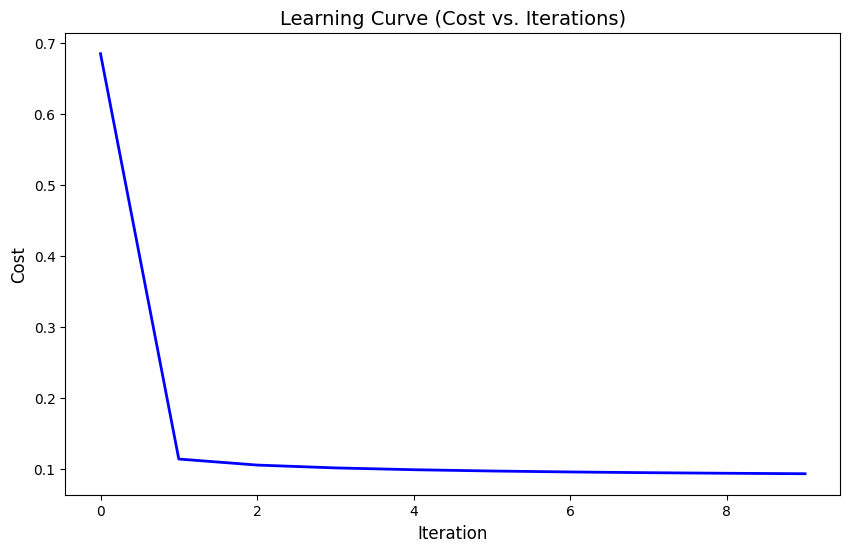

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(cost_history)),  # X-axis: iteration numbers (0 to 9999)
    cost_history,              # Y-axis: cost values
    color='blue',
    linestyle='solid',
    linewidth=2
)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.title('Learning Curve (Cost vs. Iterations)', fontsize=14)
plt.show()


In [36]:
w,b

(array([-1.98560516,  1.75302411, -0.05457523,  0.35981261,  0.40615565,
        -0.36889214, -0.53414626, -0.45929396, -1.22872989, -3.42607722,
         1.27302407]),
 np.float64(0.6959044029053993))

# Now_training Logistic Model of Logistic Regression (ridge (l2 regularized) and lasso(l1 regularized)

In [43]:
lasso_regression = LogisticRegression(penalty = 'l1',solver = 'liblinear',C = 1.0,max_iter = 100000,random_state = 42)
lasso_regression.fit(X_train,y_train)
y_pred = lasso_regression.predict(X_test)
accuracy_score(y_test,y_pred)


0.967

In [45]:
W = lasso_regression.coef_
b = lasso_regression.intercept_
W,b

(array([[-2.08145489,  1.84867303, -0.03856457,  0.29341673,  0.40523131,
         -0.34613844, -0.49467169, -0.53865868, -1.21093493, -4.67090307,
          1.85291686]]),
 array([0.72040019]))

In [46]:
W_lasso = np.array([-2.08145489,  1.84867303, -0.03856457,  0.29341673,  0.40523131,
         -0.34613844, -0.49467169, -0.53865868, -1.21093493, -4.67090307,
          1.85291686])
b_lasso = 0.72040019

In [49]:
i = 0
for col in train_df.columns:
  print(f"{col}  : {i}")
  i += 1

profile pic  : 0
nums/length username  : 1
fullname words  : 2
nums/length fullname  : 3
name==username  : 4
description length  : 5
external URL  : 6
private  : 7
#posts  : 8
#followers  : 9
#follows  : 10
fake  : 11


In [ ]:
def process_and_predict_selected(record_selected,pt, scaler,w, b,threshold):
    """
    record_selected : 1-D numpy array containing ONLY the `selected_columns`
                      and in that exact order.
    """
    # Make sure we’re working with floats
    record_selected = record_selected.astype(float)
    df_selected = pd.DataFrame(record_selected, columns = X_train.columns)
    non_binary_indices = [1,2,3,5,8,9,10]

    # ----- 3.1 Power-Transform the non-binary part ‑--–
    df_transformed = pt.transform(df_selected[non_binary_columns])

    processed = record_selected.copy()
    processed[rel_non_bin_idx] = nb_transformed.ravel()

    # ----- 3.2 Standard-scale *all* selected features ‑--–
    processed_scaled = scaler.transform(processed.reshape(1, -1))

    # ----- 3.3 Logistic score & decision ‑--–
    prob_fake = sigmoid(processed_scaled @ w + b)[0]   # scalar
    is_not_fake = prob_fake < threshold                 # True == not-fake

    return is_not_fake, prob_fake

In [ ]:
all_records = {
    "Person 1": np.array([1, 0.25,   7, 0, 19, 0,   0, 220]),
    "Person 2": np.array([1, 0.17,22, 0, 37, 0,   7, 308]),
    "Person 3": np.array([1, 0.16,13, 0,  0, 0,   0, 736]),
    "Person 4": np.array([0, 0.11,17, 0,  0, 0,   0, 247]),
    "Person 5": np.array([0, 0.18,16, 0, 19, 0,   0, 312]),
    "Random 1": np.array([0, 0.05,   6,0.15,20, 1, 788, 69978])
}

In [ ]:
threshold = 0.85
for name, rec in all_records.items():
    ok, p = process_and_predict_selected(rec, pt_train_data, scaler_train_data, W_lasso, b_lasso,threshold)
    verdict = "Not-Fake " if ok else "Fake "
    print(f"{name:10s} → {verdict}  (prob_fake = {p:.4f})")

Person 1   → Not-Fake ✅  (prob_fake = 0.8422)
Person 2   → Not-Fake ✅  (prob_fake = 0.1844)
Person 3   → Not-Fake ✅  (prob_fake = 0.8355)
Person 4   → Fake ❌  (prob_fake = 0.9945)
Person 5   → Fake ❌  (prob_fake = 0.9929)
Random 1   → Not-Fake ✅  (prob_fake = 0.0289)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skle